## Transfer Learning implementation on Dementia Dataset using VGG 16

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import cv2 as cv
import os, sys

# **Dataset Preparation**

For every file

1. Read the image
2. Resize to (224,224)
4. Preprocessing: Normalization
5. Reshape to (224,224,3)
6. Create the dataset

In [9]:
path1='Alzheimer Dataset/NonDemented'
path2='Alzheimer Dataset/MildDemented'
path3='Alzheimer Dataset/ModerateDemented'
files1=os.listdir(path1)
files2=os.listdir(path2)
files3=os.listdir(path3)
Num_files_N=len(files1)
Num_files_MD=len(files2)
Num_files_D=len(files3)
dataset_len=Num_files_N+Num_files_MD+Num_files_D

In [10]:
data=np.zeros((dataset_len,224,224,3))
label=[]
data.shape

(253, 224, 224, 3)

In [11]:
for i in range(Num_files_N):
    name=path1+'/'+files1[i]
    img=cv.imread(name)
    img_gs=cv.resize(img,(224,224))
    img_gs=img_gs/255
    img_gs=img_gs.reshape(224,224,3)
    data[i,:,:]=img_gs
    label.append('Normal')


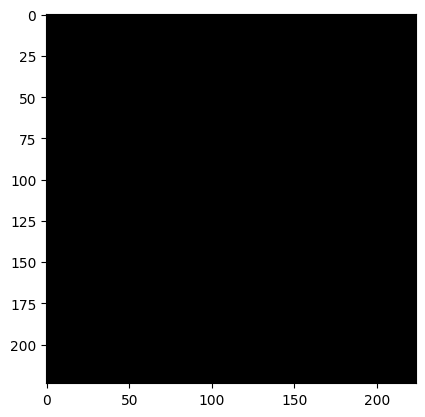

In [12]:
plt.imshow(data[100],cmap='gray')

In [13]:
for i in range(Num_files_MD):
    name=path2+'/'+files2[i]
    img=cv.imread(name)
    img_gs=cv.resize(img,(224,224))
    img_gs=img_gs/255
    img_gs=img_gs.reshape(224,224,3)
    data[i+Num_files_N,:,:]=img_gs
    label.append('Mild Dementia')

In [14]:
for i in range(Num_files_D):
    name=path3+'/'+files3[i]
    img=cv.imread(name)
    img_gs=cv.resize(img,(224,224))
    img_gs=img_gs/255
    img_gs=img_gs.reshape(224,224,3)
    data[i+Num_files_N+Num_files_MD,:,:]=img_gs
    label.append('Dementia')


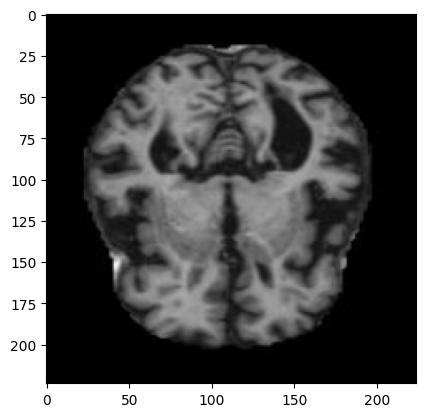

In [15]:
plt.imshow(data[100],cmap='gray')

Label Encoding

In [16]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
lab=le.fit_transform(label)

Train and test dataset spilt

In [17]:
train_images,test_images,train_labels,test_labels=train_test_split(data,lab,test_size=0.2,random_state=1)

In [18]:
print('Train Dataset Size:',np.size(train_labels))
print('Test Dataset Size:',np.size(test_labels))

Train Dataset Size: 202
Test Dataset Size: 51


# Define the VGG-16 Net

**Import VGG16 network**

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


Load the vgg16 base model

Freeze the convolutional base and fine tune only the classifier

In [20]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=train_images[0].shape)
#base_model=VGG16(weights='imagenet',include_top=True)
base_model.trainable=False

58889256/58889256 [==============================] - 5s 0us/step


Check summary of convolutional base

In [21]:
train_ds=tf.image.resize(train_images,(224,224))
test_ds=tf.image.resize(test_images,(224,224))

Build the classifier on top of the convolutional base

In [22]:
train_ds=preprocess_input(train_images)
test_ds=preprocess_input(test_images)

In [23]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
from tensorflow.keras import layers, models

In [25]:
flatten_layer=layers.Flatten()
dense_1=layers.Dense(50,activation='relu')
dense_2=layers.Dense(20,activation='relu')
pred_layer=layers.Dense(3,activation='softmax')

In [26]:
networks=models.Sequential([
    base_model,
    flatten_layer,
    dense_1,
    dense_2,
    pred_layer
])

In [27]:
networks.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 3)                 63        
                                                                 
Total params: 15,970,221
Trainable params: 1,255,533
Non-trainable params: 14,714,688
_________________________________________________________________


In [28]:
networks.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
             )

In [29]:
trained_net=networks.fit(train_ds,train_labels,epochs=100,validation_data=(test_ds,test_labels),batch_size=64)

Epoch 1/100
4/4 [==============================] - 11s 2s/step - loss: 2.4816 - accuracy: 0.2624 - val_loss: 1.3544 - val_accuracy: 0.2549
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 1.2220 - accuracy: 0.2970 - val_loss: 1.2028 - val_accuracy: 0.2941
Epoch 3/100
4/4 [==============================] - 10s 2s/step - loss: 1.0998 - accuracy: 0.4307 - val_loss: 1.0804 - val_accuracy: 0.4510
Epoch 4/100
4/4 [==============================] - 10s 3s/step - loss: 1.0609 - accuracy: 0.3861 - val_loss: 1.1000 - val_accuracy: 0.2941
Epoch 5/100
4/4 [==============================] - 10s 3s/step - loss: 1.0509 - accuracy: 0.4059 - val_loss: 1.1047 - val_accuracy: 0.3137
Epoch 6/100
4/4 [==============================] - 10s 2s/step - loss: 1.0571 - accuracy: 0.4208 - val_loss: 1.1378 - val_accuracy: 0.2941
Epoch 7/100
4/4 [==============================] - 16s 4s/step - loss: 1.0551 - accuracy: 0.3713 - val_loss: 1.0813 - val_accuracy: 0.4510
Epoch 8/100
4/4 [===========



```
# This is formatted as code
```

# Unfreeze few convolutional layers in convolutional base

In [ ]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=train_images[0].shape)
base_model.trainable=False

In [ ]:
for layer in base_model.layers[15:]:
    layer.trainable=True

In [ ]:
for layer in base_model.layers:
    print("{}:{}".format(layer, layer.trainable))

<keras.src.engine.input_layer.InputLayer object at 0x7ee5c80988e0>:False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ee5c8098ac0>:False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ee5c7cfe080>:False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ee5c80e8a00>:False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ee5c7c671c0>:False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ee5c80eafb0>:False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ee5ac2f49a0>:False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ee5c80f8ca0>:False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ee5ac320520>:False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ee5dbab54e0>:False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ee5c8082f80>:False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ee5c7f137c0>:False
<keras.src.layers.convolutional.conv2d.Conv2D ob

In [ ]:
model=models.Sequential([
    base_model,
    flatten_layer,
    dense_1,
    dense_2,
    pred_layer
])


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
             )

In [ ]:
trained_model=model.fit(train_ds,train_labels, epochs=5, validation_data=(test_ds,test_labels),batch_size=64)

Epoch 1/5
4/4 [==============================] - 155s 39s/step - loss: 1.6601 - accuracy: 0.3020 - val_loss: 1.8040 - val_accuracy: 0.2941
Epoch 2/5
4/4 [==============================] - 149s 39s/step - loss: 1.5579 - accuracy: 0.4208 - val_loss: 1.6595 - val_accuracy: 0.4510
Epoch 3/5
4/4 [==============================] - 137s 34s/step - loss: 1.3425 - accuracy: 0.3812 - val_loss: 1.1189 - val_accuracy: 0.4510
Epoch 4/5
4/4 [==============================] - 138s 35s/step - loss: 1.2710 - accuracy: 0.2723 - val_loss: 1.1819 - val_accuracy: 0.2941
Epoch 5/5
4/4 [==============================] - 151s 38s/step - loss: 1.1808 - accuracy: 0.4257 - val_loss: 1.4590 - val_accuracy: 0.2941


plot accuracy curves

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trained_model.history['accuracy'],label='Training Accuracy')
plt.plot(trained_model.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1.1])
plt.legend(loc='lower right')

plot loss curves

In [ ]:
plt.plot(trained_model.history['loss'],label='Training Loss')
plt.plot(trained_model.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [ ]:
plt.plot(trained_net.history['accuracy'],label='Training Accuracy')
plt.plot(trained_net.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1.1])
plt.legend(loc='lower right')

In [ ]:
plt.plot(trained_net.history['loss'],label='Training Loss')
plt.plot(trained_net.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')